In [1]:
! pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d tanjemahamed/odir5k-classification

Dataset URL: https://www.kaggle.com/datasets/tanjemahamed/odir5k-classification
License(s): other
100% 372M/374M [00:17<00:00, 22.6MB/s]
100% 374M/374M [00:17<00:00, 22.1MB/s]


In [4]:
!unzip /content/odir5k-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: datasets/diabetes/image300.png  
  inflating: datasets/diabetes/image301.png  
  inflating: datasets/diabetes/image302.png  
  inflating: datasets/diabetes/image303.png  
  inflating: datasets/diabetes/image304.png  
  inflating: datasets/diabetes/image305.png  
  inflating: datasets/diabetes/image306.png  
  inflating: datasets/diabetes/image307.png  
  inflating: datasets/diabetes/image308.png  
  inflating: datasets/diabetes/image309.png  
  inflating: datasets/diabetes/image31.png  
  inflating: datasets/diabetes/image310.png  
  inflating: datasets/diabetes/image311.png  
  inflating: datasets/diabetes/image312.png  
  inflating: datasets/diabetes/image313.png  
  inflating: datasets/diabetes/image314.png  
  inflating: datasets/diabetes/image315.png  
  inflating: datasets/diabetes/image316.png  
  inflating: datasets/diabetes/image317.png  
  inflating: datasets/diabetes/image318.png  
  inflating: datasets/diabetes

In [28]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
os.makedirs("train", exist_ok=True)
os.makedirs("val", exist_ok=True)

In [7]:
dataset_dir = '/content/datasets'
train_dir = '/content/train'
val_dir = '/content/val'

In [9]:
train_ratio = 0.6
val_ratio = 0.4

In [10]:
# Untuk setiap sub-folder (kategori)
for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)

    if os.path.isdir(category_path):
        # Buat folder kategori di train dan validation
        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(val_category_dir, exist_ok=True)

        # Ambil semua file gambar dalam folder kategori
        images = os.listdir(category_path)
        random.shuffle(images)  # Acak urutan gambar

        # Tentukan jumlah gambar untuk train dan validation
        train_size = int(len(images) * train_ratio)
        val_size = len(images) - train_size

        # Pisahkan gambar untuk train dan validation
        train_images = images[:train_size]
        val_images = images[train_size:]

        # Pindahkan gambar ke folder yang sesuai
        for img in train_images:
            shutil.move(os.path.join(category_path, img), os.path.join(train_category_dir, img))

        for img in val_images:
            shutil.move(os.path.join(category_path, img), os.path.join(val_category_dir, img))

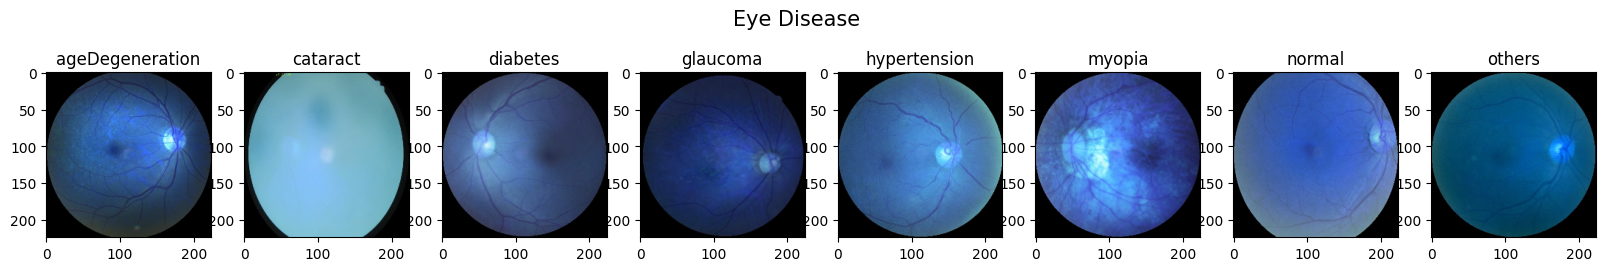

In [11]:
fig, axes = plt.subplots(1, 8, figsize=(20, 3))
fig.suptitle('Eye Disease', fontsize=15)

for ii, disease in enumerate(['ageDegeneration' , 'cataract', 'diabetes', 'glaucoma', 'hypertension', 'myopia','normal','others']):
    dir = f'./train/{disease}'
    img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
    axes[ii].imshow(img)
    axes[ii].set_title(f'{disease}')

In [12]:
TRAIN_DIR = '/content/train/'
VALIDATION_DIR = '/content/val'

In [13]:
def train_val_datasets():


    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=32,
        image_size=(255,255),
		    label_mode='categorical',
        color_mode = "rgb",
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,
        image_size=(255,255),
		    label_mode='categorical',
        color_mode = "rgb",
    )

    return train_dataset, validation_dataset

In [14]:
train_dataset, validation_dataset = train_val_datasets()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")

Found 3830 files belonging to 8 classes.
Found 2562 files belonging to 8 classes.
Images of train dataset have shape: (None, 255, 255, 3)
Labels of train dataset have shape: (None, 8)
Images of validation dataset have shape: (None, 255, 255, 3)
Labels of validation dataset have shape: (None, 8)


In [24]:
def create_model():
    # Load the base MobileNetV2 model, excluding the top layer
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(255, 255, 3)
    )

    # Unfreeze the top layers for fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:-30]:  # Freeze all layers except the last 30
        layer.trainable = False

    model = models.Sequential([
        layers.Input(shape=(255, 255, 3)),

        # Data augmentation
        layers.Rescaling(1./255),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),

        # MobileNetV2 base model
        base_model,

        # Pooling and classification layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),  # Increase units in dense layer
        layers.Dropout(0.4),  # Increase dropout rate for better regularization
        layers.Dense(8, activation='softmax')  # Output layer for 4 classes
    ])

    # Compile the model with a lower learning rate for fine-tuning
    model.compile(
        optimizer=Adamax(learning_rate=1e-4),  # Lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [25]:
model = create_model()

<ipython-input-24-ed09b7a66ae9>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [26]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_3 (RandomFlip)           │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 1,856,392 (7.08 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [29]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    min_delta=0.001,
    mode='max',
    baseline=0.95,
    restore_best_weights=True
)

In [32]:
# Train your model
history = model.fit(train_dataset,
                    epochs=200,
                    callbacks=[early_stopping],
                    validation_data=validation_dataset)

Epoch 1/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.3973 - loss: 1.6595 - val_accuracy: 0.4532 - val_loss: 1.5594
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.5341 - loss: 1.2850 - val_accuracy: 0.4614 - val_loss: 1.5558
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.5348 - loss: 1.2240 - val_accuracy: 0.4680 - val_loss: 1.5814
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - accuracy: 0.5385 - loss: 1.1953 - val_accuracy: 0.4672 - val_loss: 1.6062
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.5790 - loss: 1.1153 - val_accuracy: 0.4711 - val_loss: 1.5293
Epoch 6/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.5957 - loss: 1.0873 - val_accuracy: 0.4996 - val_loss: 1.3853
Epoch 7/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.5922 - loss: 1.0638 - val_accuracy: 0.5277 - val_loss: 1.3175
Epoch 8/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.6028 -